In [1]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
import pandas as pd

import scipy.sparse as scs
from sklearn.utils.extmath import randomized_svd

In [2]:
def random_matrix(n,m,density):
    A = scs.random(n,m,density)
    return A.toarray()


Rekurencyjna kompresja

In [3]:
class Node:
    def __init__(self, t_min, t_max, s_min, s_max):
        self.t_min = t_min
        self.t_max = t_max
        
        self.s_min = s_min
        self.s_max = s_max
        
        self.rank = None
        
        #[A11, A12]
        #[A21, A22]
        
        self.U = None
        self.S = None
        self.VT = None
        
        self.zeros = False
        
        
        self.children = []
        
        


In [4]:
def is_admissible(matrix, S, r, eps):
    if min(matrix.shape) <= r:
        return True
    
    if S[-1] < eps:
        return True
    
    return False     

In [5]:
def create_tree(matrix, r, eps):
    n, m = matrix.shape

    
    def create_tree_r(t_min, t_max, s_min, s_max):
        nonlocal matrix, r, eps
        
        if not np.any(matrix[t_min:t_max, s_min:s_max]):
            v = Node(t_min, t_max, s_min, s_max)
            v.rank = 0
            v.zeros = True
            return v
    
        U,S,V = randomized_svd(matrix[t_min:t_max, s_min:s_max], r)
        
        S = S[S >= eps]  
        rank = len(S)
        
        U = U[:, :rank]
        V = V[:rank, :]
        if rank == 0:
            v = Node(t_min, t_max, s_min, s_max)
            v.rank = 0
            v.zeros = True
            return v
        
        
        if is_admissible(matrix[t_min:t_max, s_min:s_max], S, r, eps):
            v = Node(t_min, t_max, s_min, s_max) #compress matrix
            v.rank = rank
            v.U = U
            v.S = S
            v.V = V
            return v
            
        else:
            v = Node(t_min, t_max, s_min, s_max)
            
            t_newmax = (t_min + t_max)//2
            s_newmax = (s_min + s_max)//2
            
            v1 = create_tree_r(t_min, t_newmax, s_min, s_newmax)
            v2 = create_tree_r(t_min, t_newmax, s_newmax, s_max)
            v3 = create_tree_r(t_newmax, t_max, s_min, s_newmax)
            v4 = create_tree_r(t_newmax, t_max, s_newmax, s_max)
            
            v.children = [v1, v2, v3, v4]
        return v
    return create_tree_r(0, n, 0, m)

In [6]:
def decompress(node):
    if node.rank is not None:
        if node.rank > 0:
            return node.U@np.diag(node.S)@node.V
        else:
            return np.zeros((node.t_max - node.t_min, node.s_max - node.s_min))
    else:
        return np.vstack(
            (
                np.hstack((decompress(node.children[0]), decompress(node.children[1]))),
                np.hstack((decompress(node.children[2]), decompress(node.children[3]))),
            )
        )   

In [42]:
s = 2**8
a = scs.random(s,s,density = 0.25)
a = a.toarray()
print(a)

[[0.01306601 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.22012151 0.         0.        ]
 [0.09304061 0.         0.         ... 0.         0.29566638 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.83838375]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.97907243 ... 0.         0.         0.        ]]


In [43]:
tree = create_tree(a, 2, 10**(-8))
#print(decompress(tree))

In [44]:
print(np.allclose(a, decompress(tree)))

True


Rysowanie

In [45]:
def plot_matrix(root, matrix, title = None):
    size = matrix.shape
    tmap = np.zeros(size)
    
    def fill_map(node):
        nonlocal tmap
        if node.rank is not None:
            if node.rank != 0:
                tmap[node.t_min:node.t_max, node.s_min:node.s_min + node.rank] = 1
                tmap[node.t_min:node.t_min + node.rank, node.s_min:node.s_max] = 1
        else:
            for submatrix in node.children:
                fill_map(submatrix)
    fill_map(root)
    f, ax = plt.subplots(1,1)
    ax.spy(tmap)
    if title is not None:
        ax.set_title(title)
        

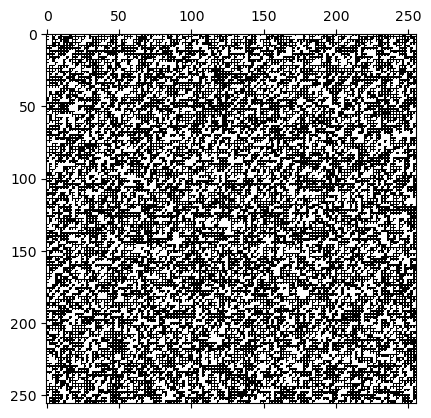

In [46]:
plot_matrix(tree, a)

Pomiary czasu

0.01 256 2 2.5192599239886837 0.018997907638549805
0.01 256 2 0.6029543842143775 0.45810389518737793
0.01 256 2 2.1967635614479378e-17 1.006227731704712
0.01 256 4 2.5192599239886837 0.01400136947631836
0.01 256 4 0.6029543842143775 0.363081693649292
0.01 256 4 2.1967635614479378e-17 0.5091342926025391
0.01 256 8 2.5192599239886837 0.016004323959350586
0.01 256 8 0.6029543842143775 0.28406333923339844
0.01 256 8 2.1967635614479378e-17 0.3160712718963623
0.01 512 2 3.444419499546536 0.019005775451660156
0.01 512 2 0.9748759134063808 0.7301630973815918
0.01 512 2 2.0079132084226882e-16 2.7445178031921387
0.01 512 4 3.444419499546536 0.021004676818847656
0.01 512 4 0.9748759134063808 0.8462152481079102
0.01 512 4 2.0079132084226882e-16 2.1296732425689697
0.01 512 8 3.444419499546536 0.023005008697509766
0.01 512 8 0.9748759134063808 0.699713945388794
0.01 512 8 2.0079132084226882e-16 1.2843146324157715
0.05 256 2 7.179215159491253 0.01400303840637207
0.05 256 2 1.6036601317743306 0.205046

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12944\3850747785.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, ax = plt.subplots(1,1)


0.05 256 2 0.002199793729844132 1.8474483489990234
0.05 256 4 7.179215159491253 0.01600360870361328
0.05 256 4 1.6036601317743306 0.19004273414611816
0.05 256 4 0.002199793729844132 1.168773889541626
0.05 256 8 7.179215159491253 0.015002965927124023
0.05 256 8 1.6036601317743306 0.17303943634033203
0.05 256 8 0.002199793729844132 0.5101497173309326
0.05 512 2 13.452699754034622 0.02000713348388672
0.05 512 2 2.27254816672369 0.2966492176055908
0.05 512 2 0.0008885102695393789 7.907989978790283
0.05 512 4 13.452699754034622 0.03800845146179199
0.05 512 4 2.27254816672369 0.3110835552215576
0.05 512 4 0.0008885102695393789 4.803885221481323
0.05 512 8 13.452699754034622 0.03500795364379883
0.05 512 8 2.27254816672369 0.32346391677856445
0.05 512 8 0.0008885102695393789 2.322995185852051
0.1 256 2 13.389145758687336 0.018003463745117188
0.1 256 2 2.2308977675451103 0.18944430351257324
0.1 256 2 0.008403361076602684 2.9783101081848145
0.1 256 4 13.389145758687336 0.021507740020751953
0.1 2

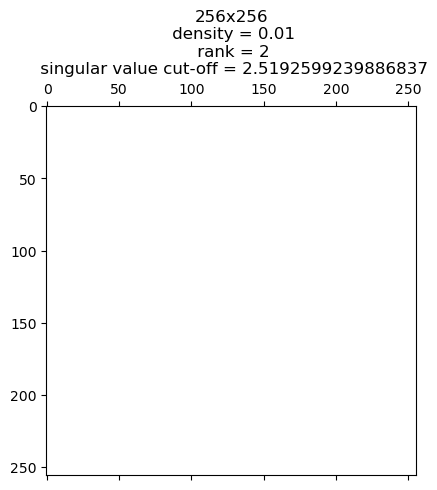

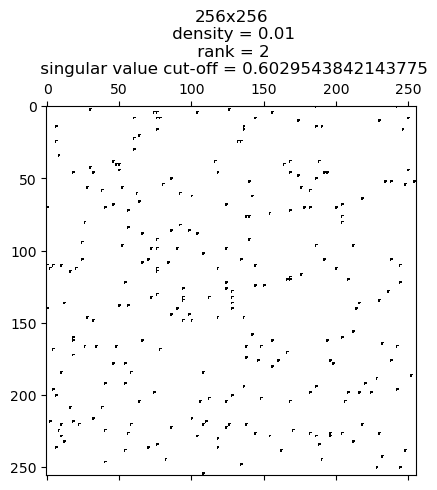

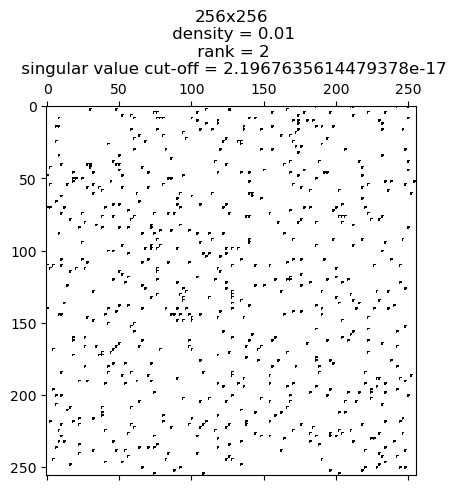

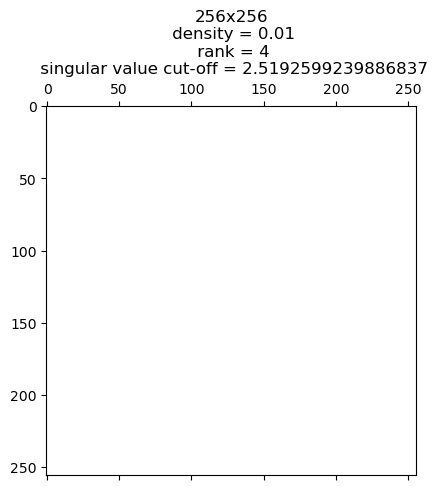

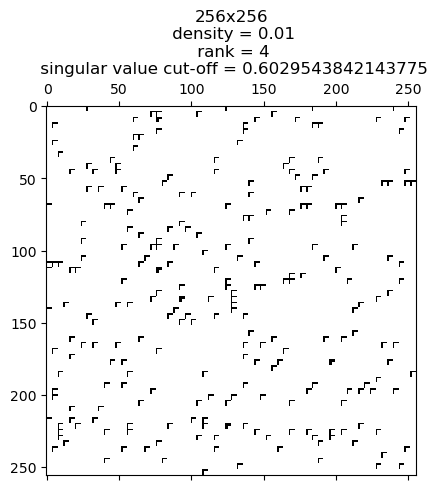

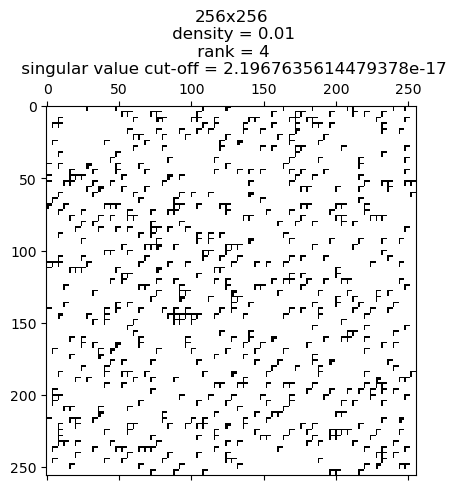

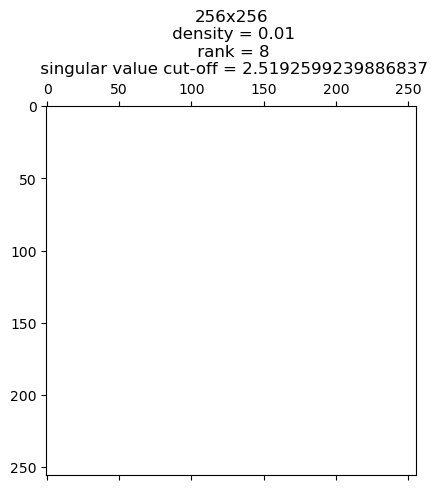

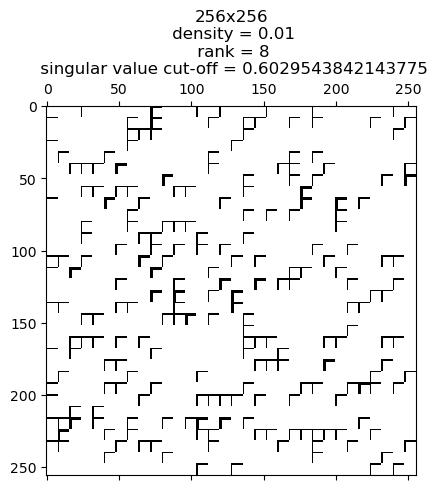

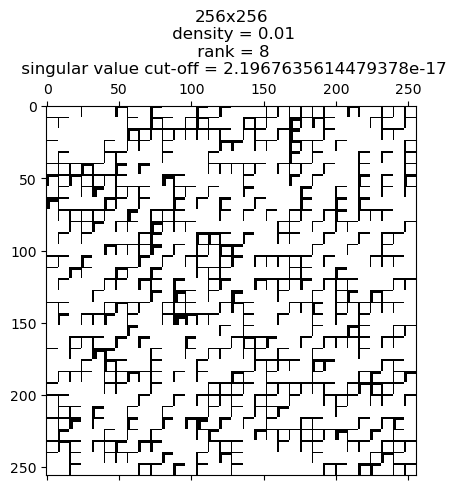

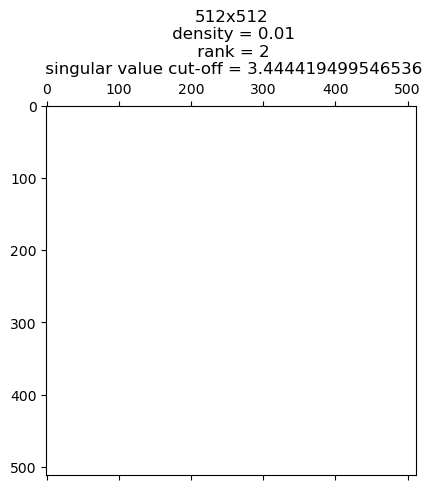

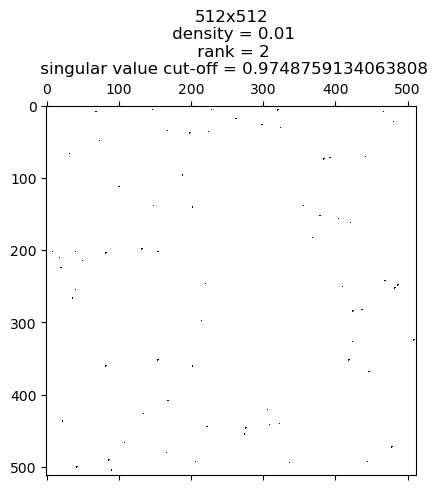

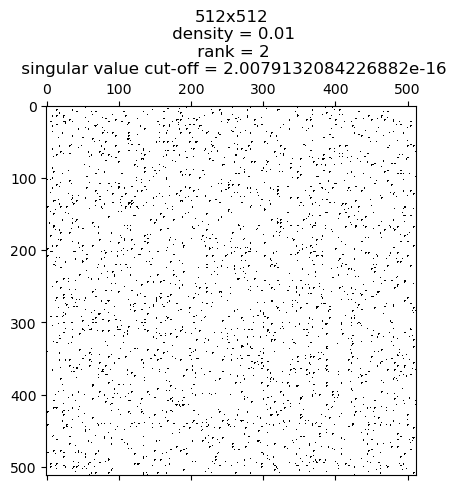

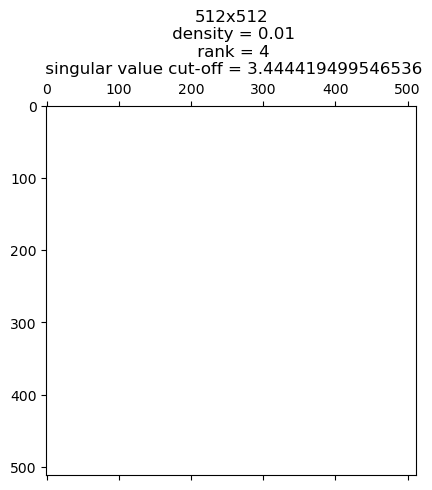

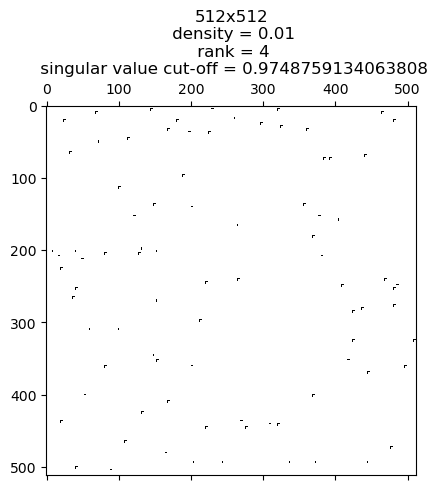

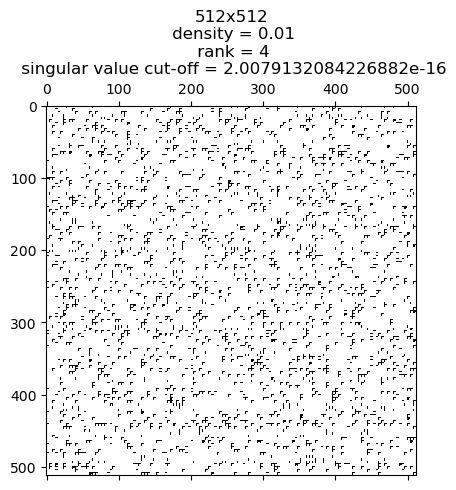

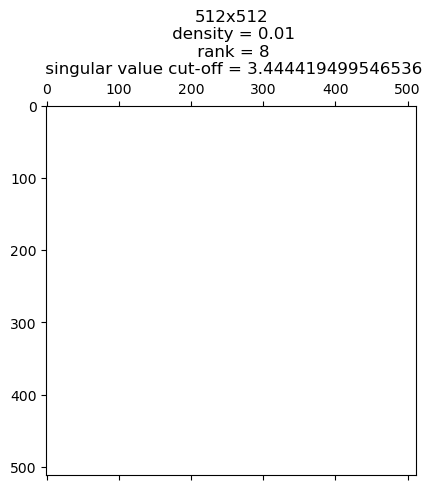

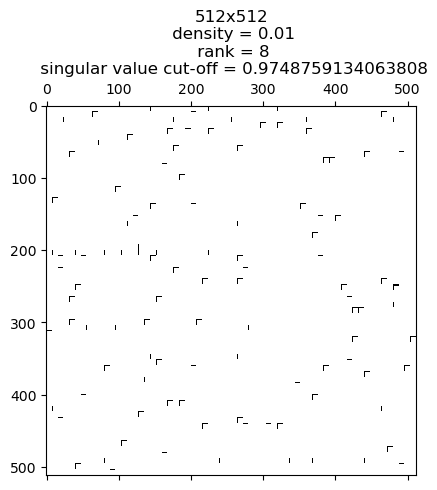

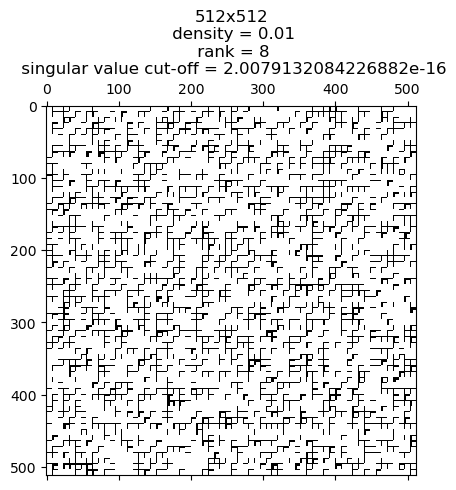

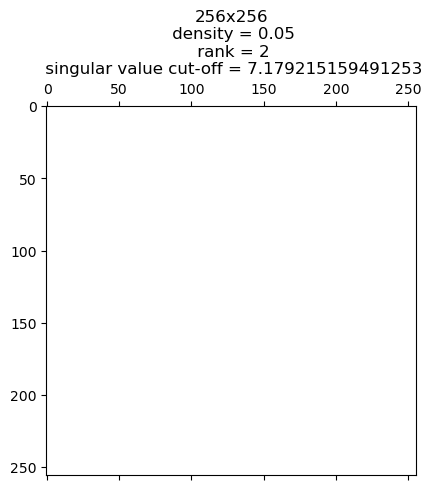

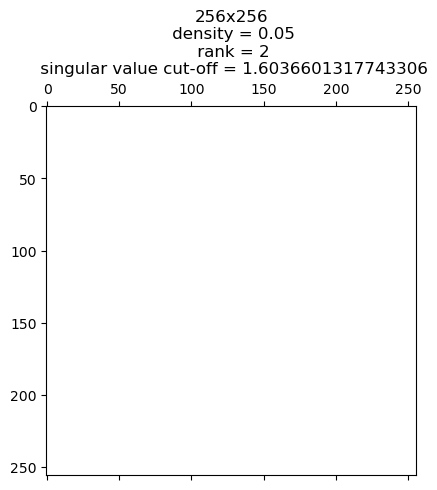

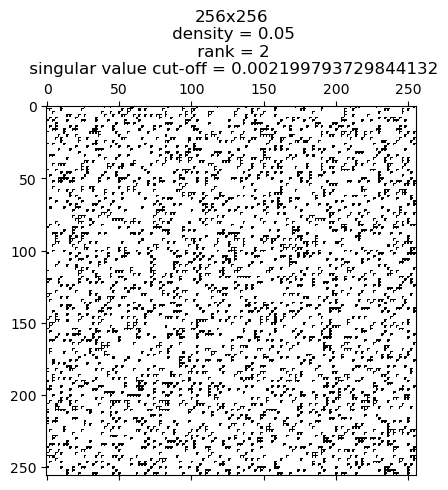

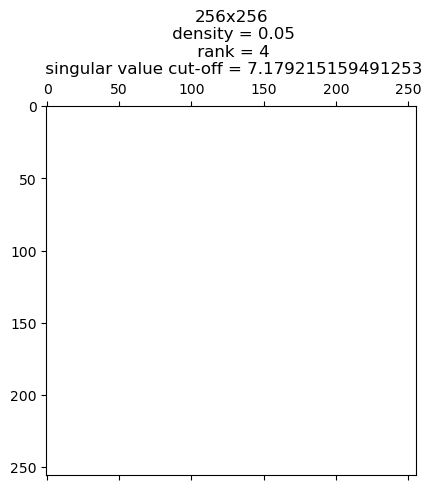

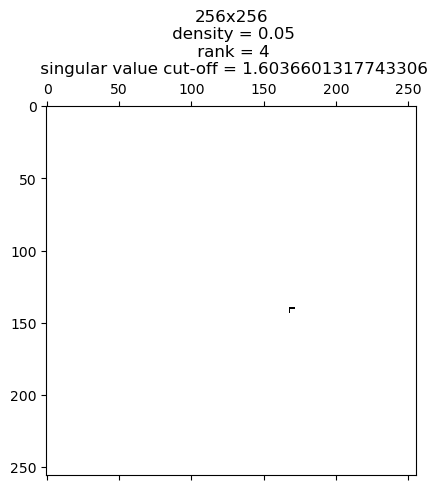

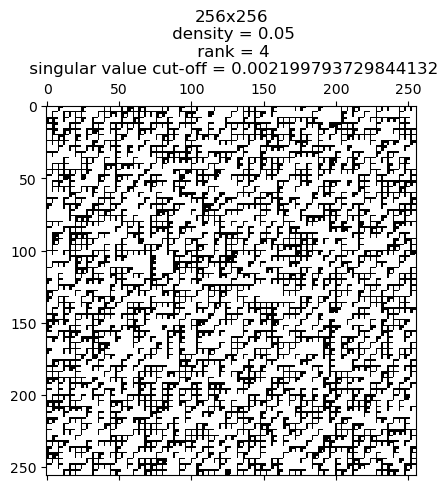

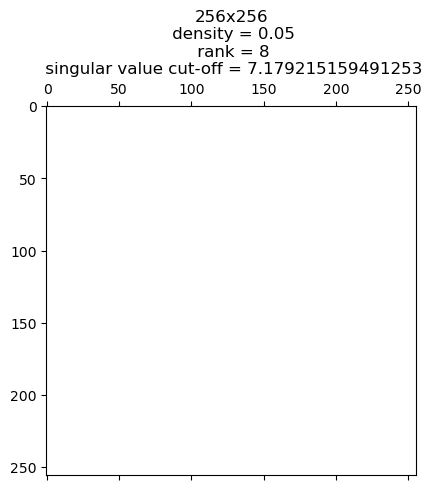

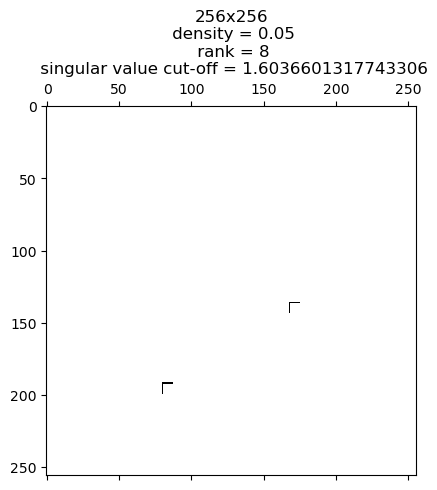

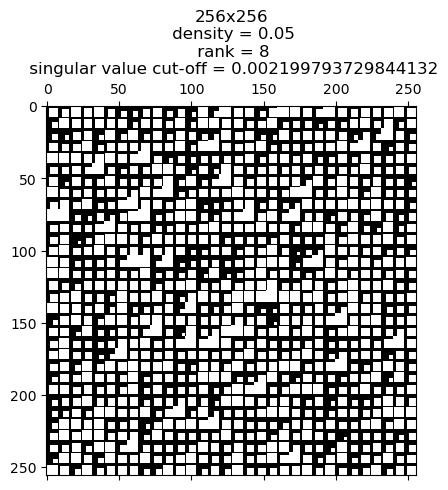

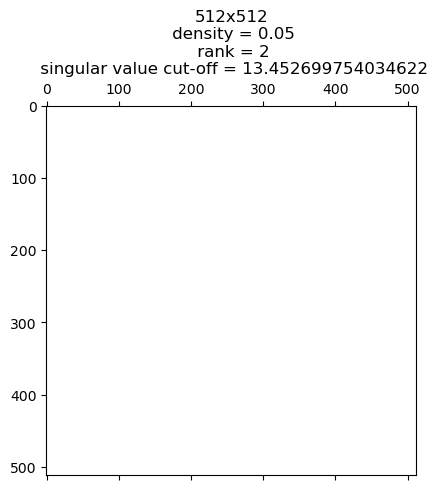

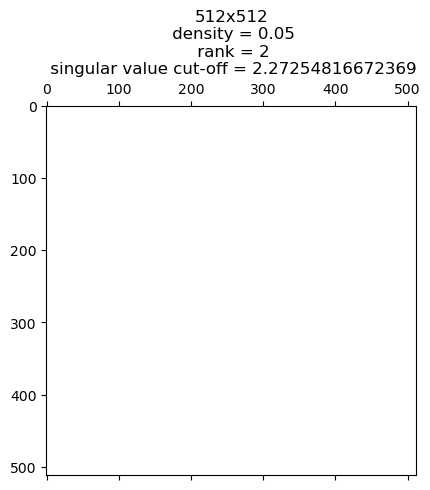

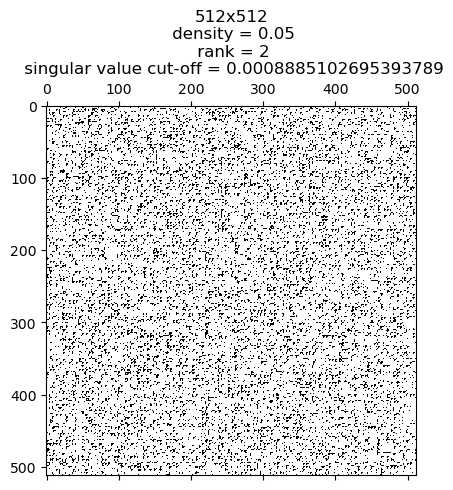

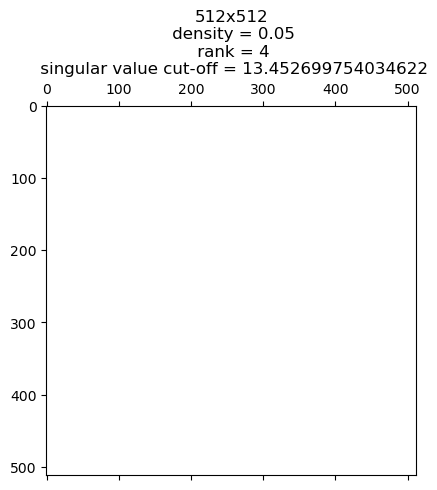

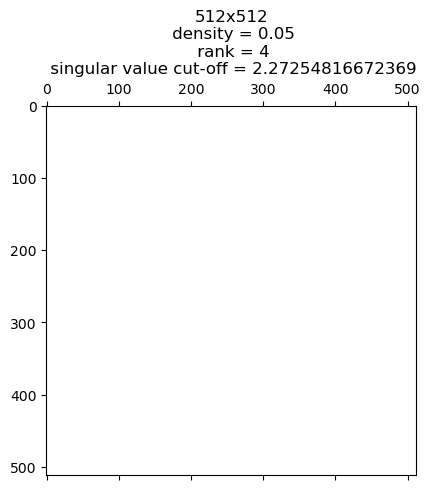

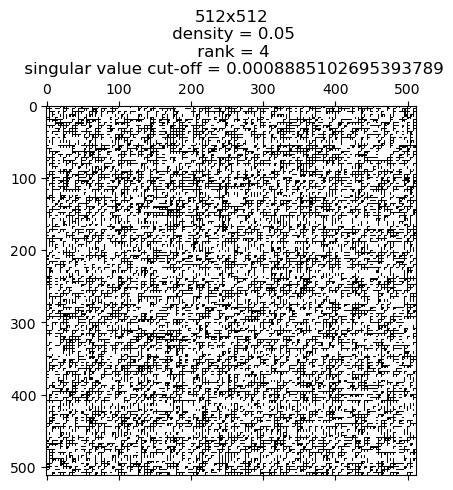

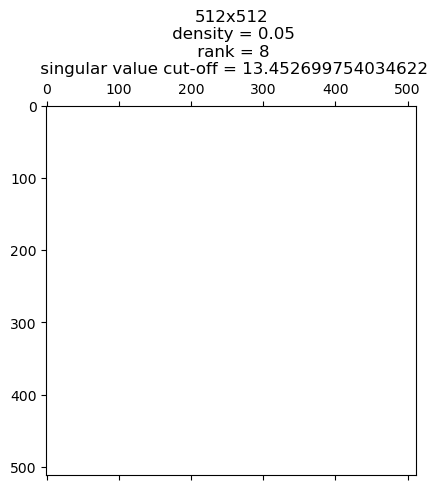

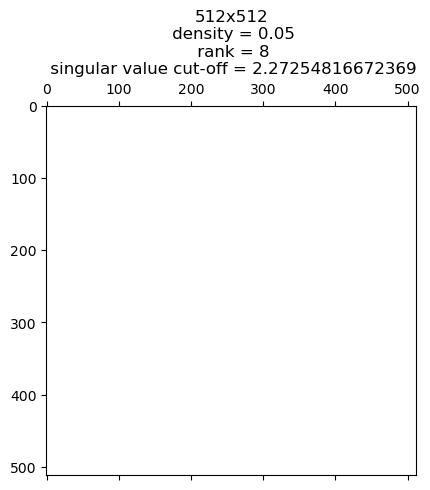

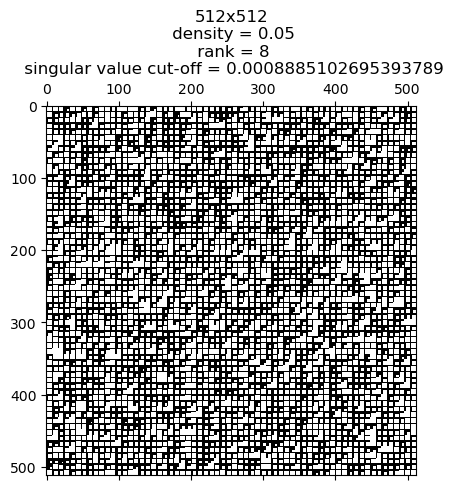

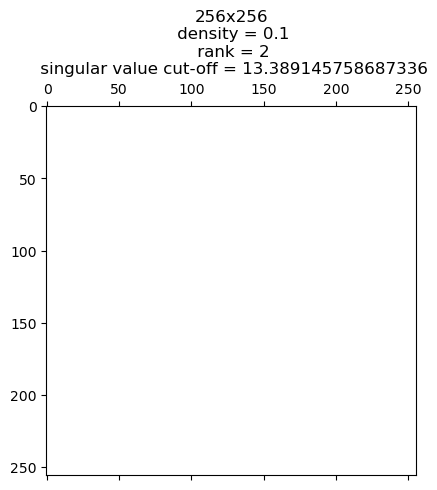

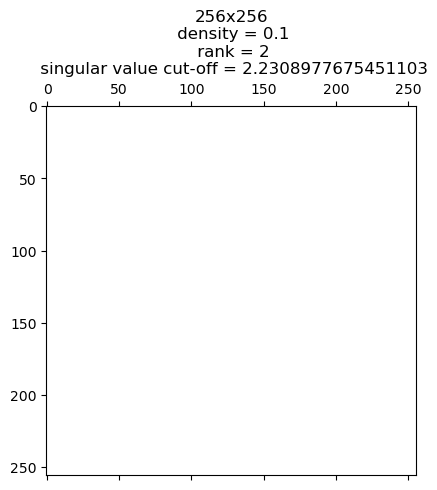

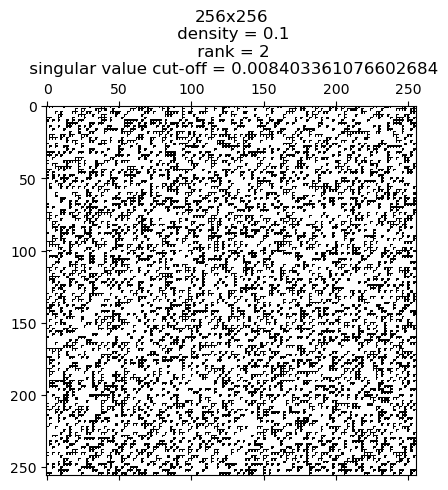

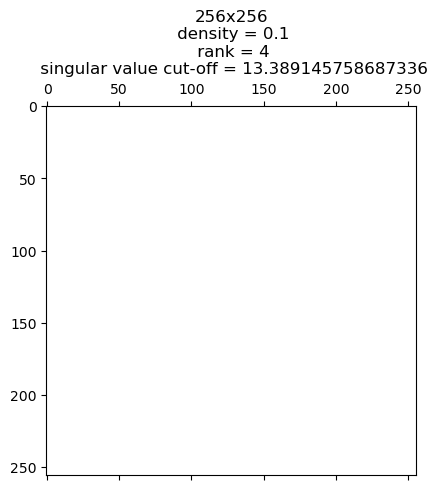

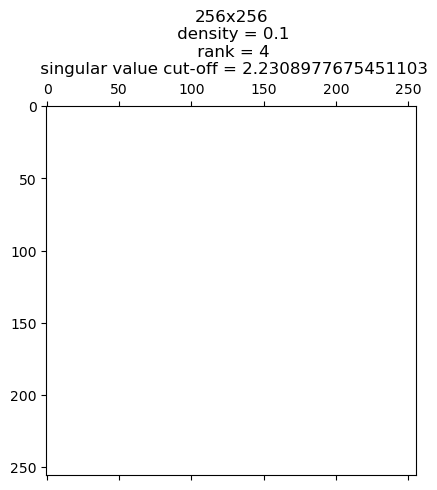

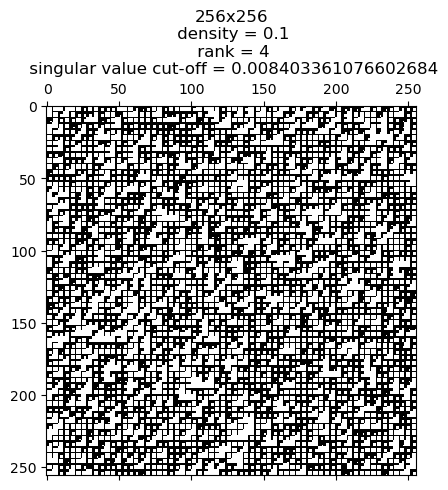

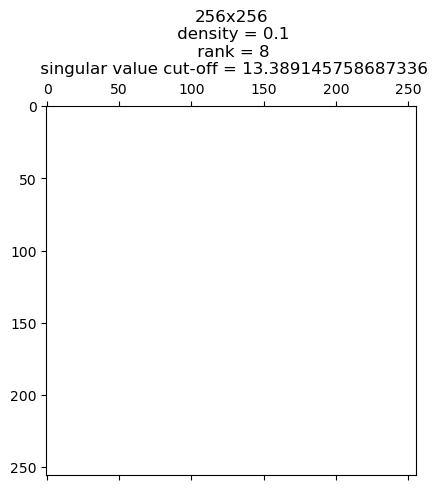

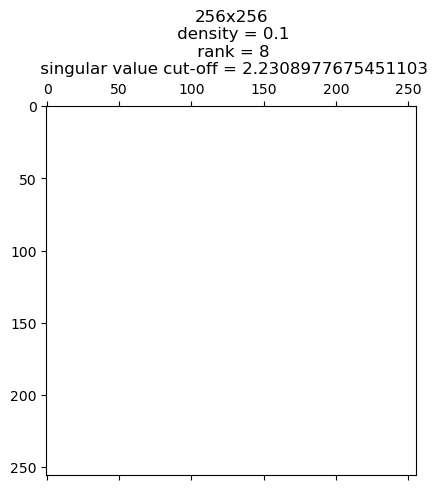

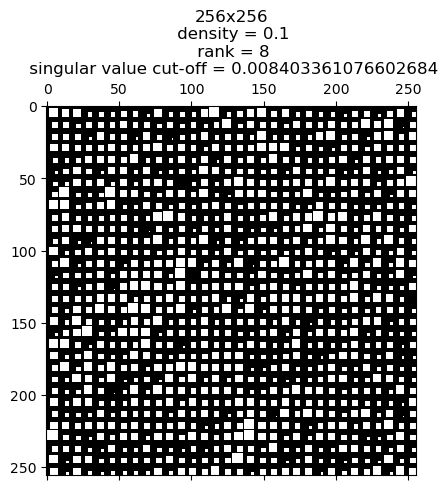

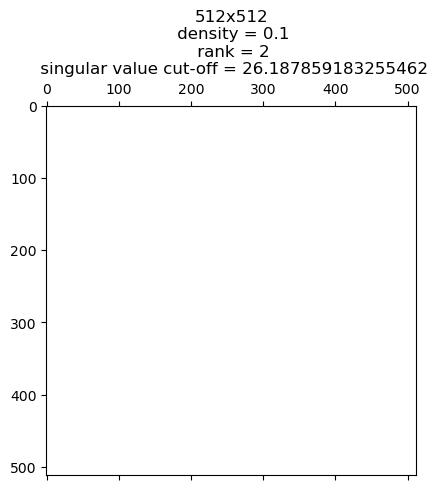

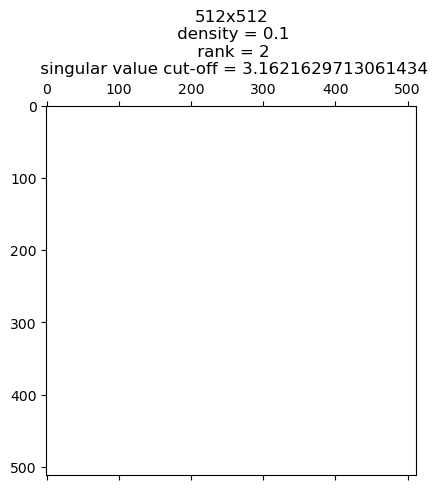

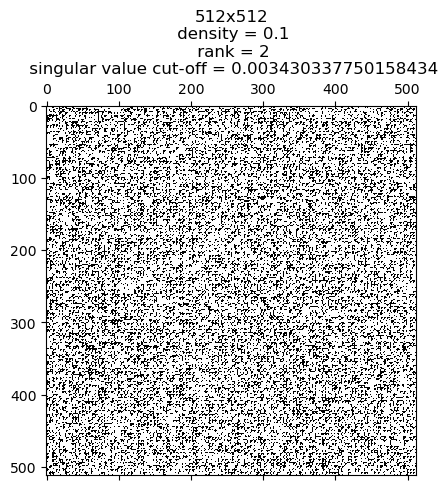

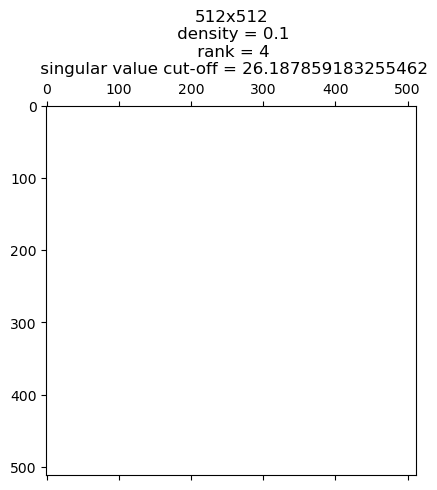

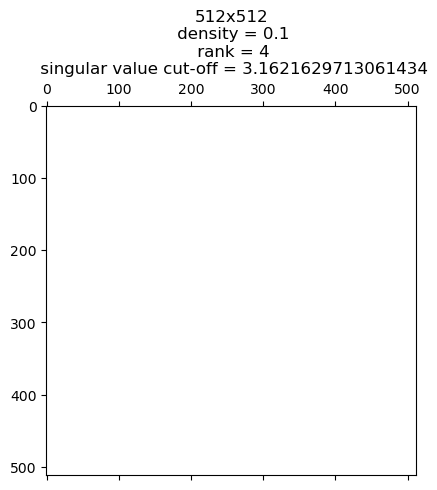

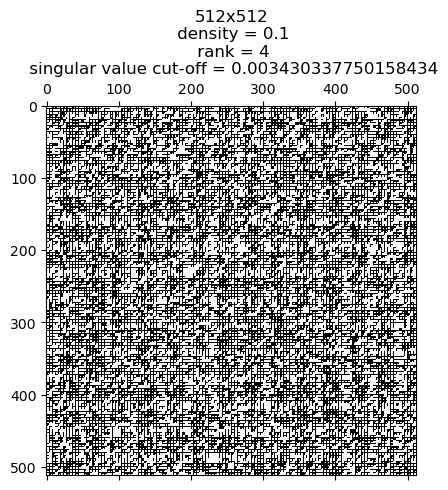

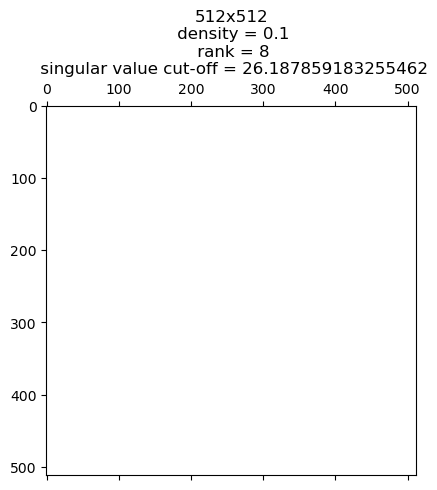

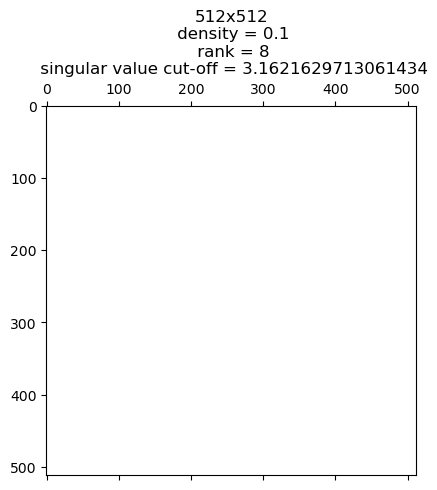

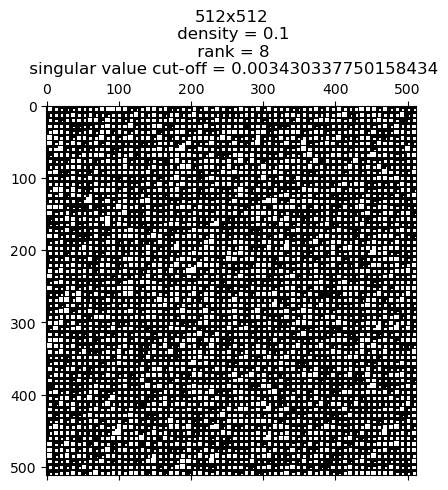

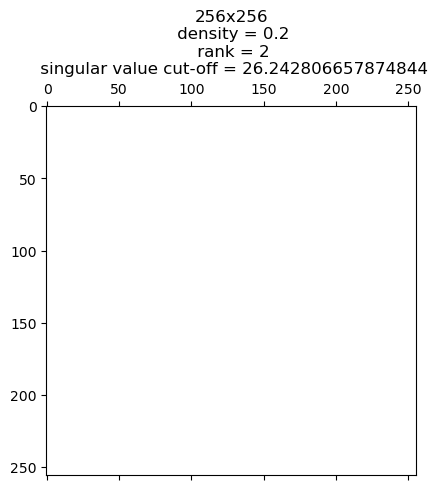

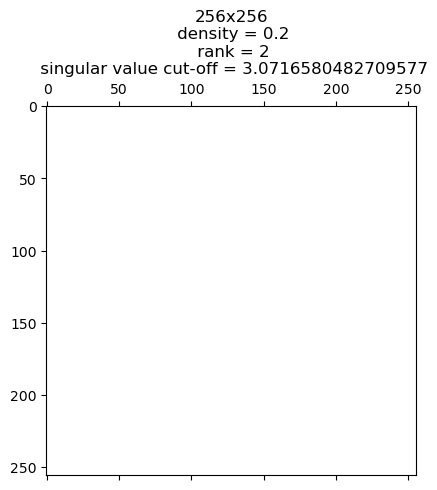

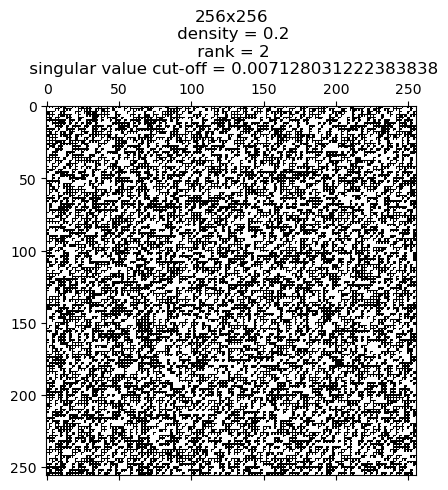

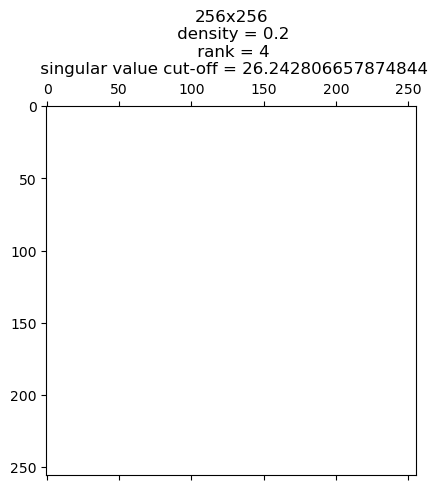

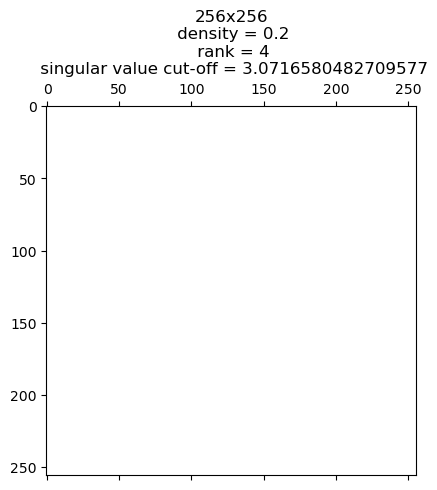

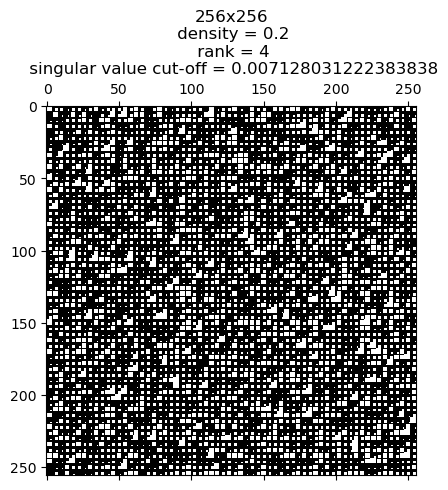

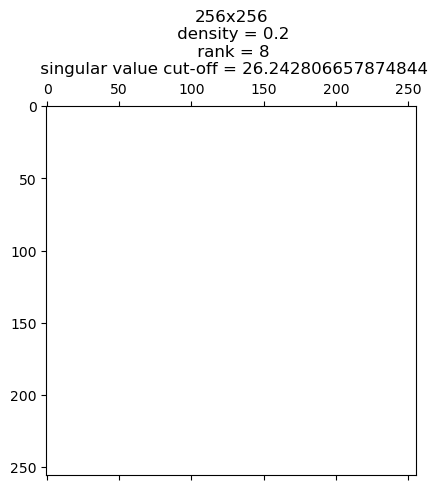

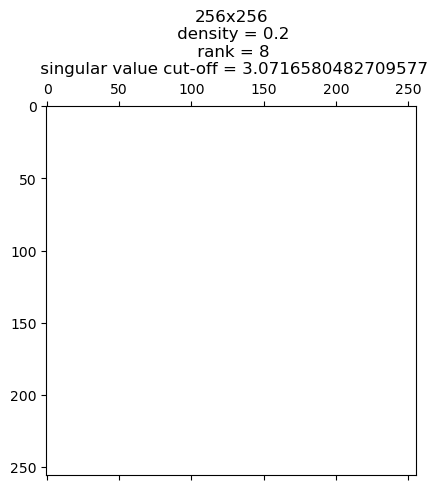

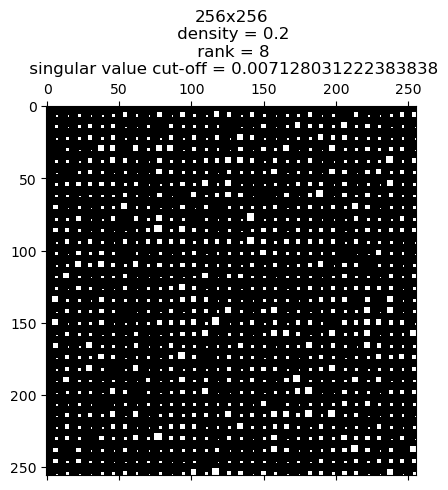

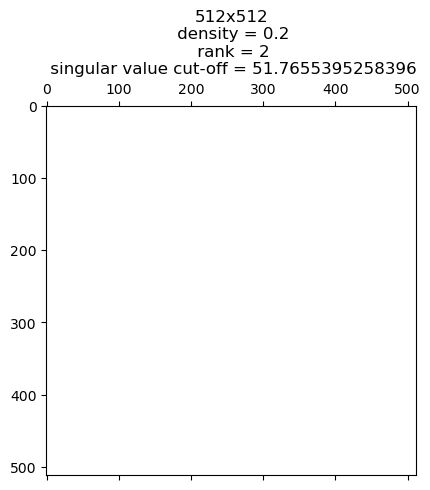

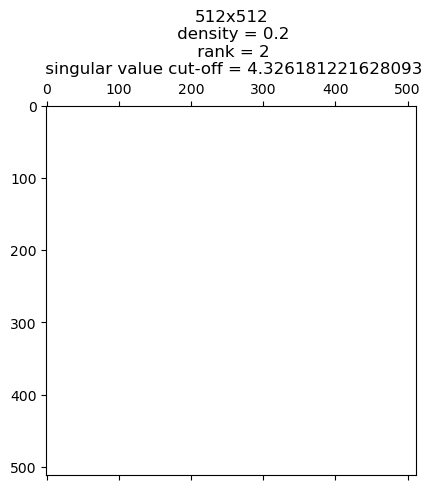

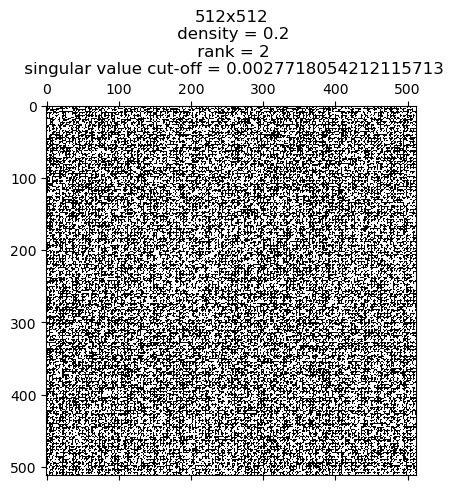

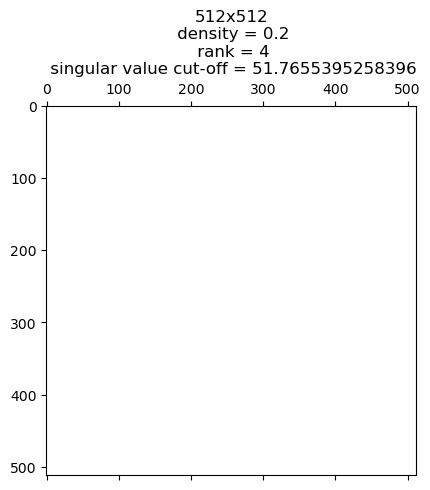

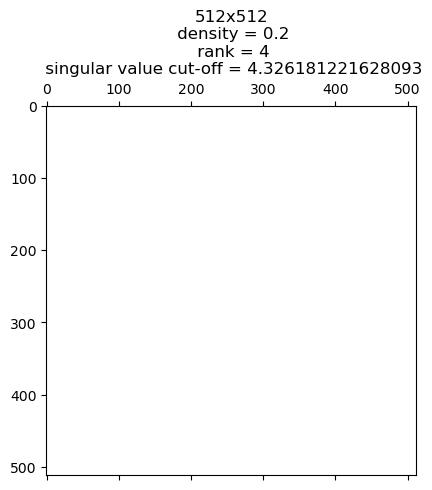

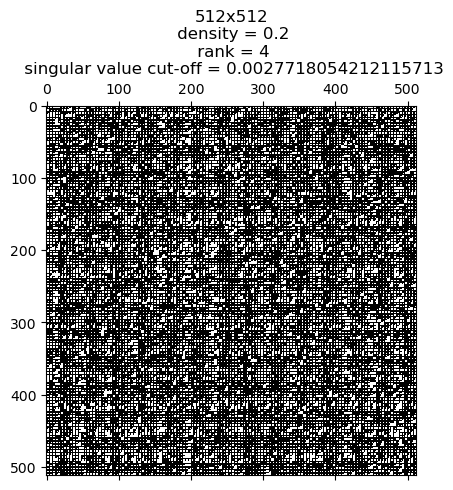

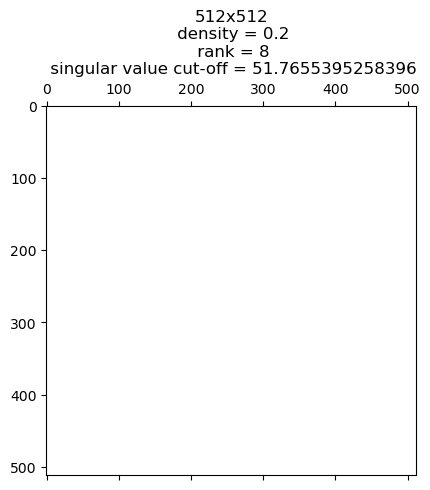

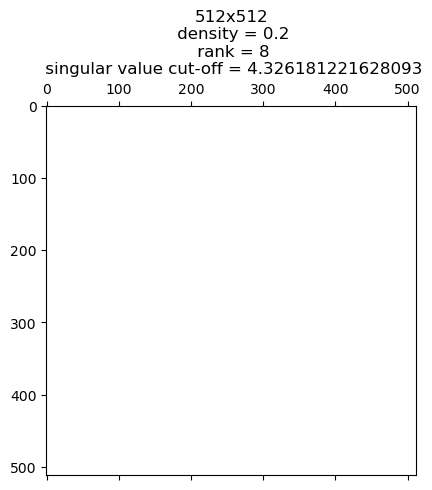

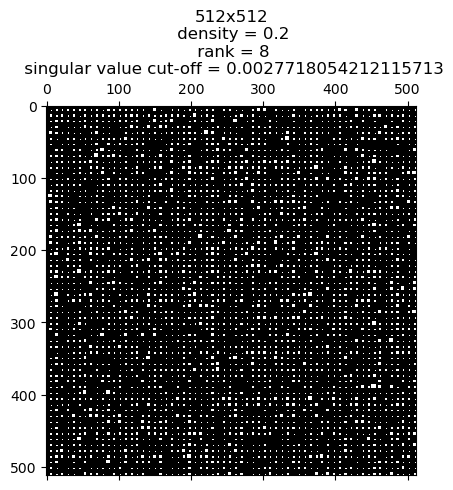

In [19]:
sizes = [2**i for i in range(8,10)]
densities = [0.01, 0.05, 0.1, 0.2]

results = {}
for density in densities:
    for size in sizes:
        matrix = random_matrix(size,size,density)
        
        _, S, _ = np.linalg.svd(matrix)
        singular_values = [('0', S[0]), ('n//2', S[size//2]), ('n', S[-1])]
        
        for b in [2,4,8]:
            for ind, singular_value in singular_values:
                start = time()
                tree = create_tree(matrix, b, singular_value)
                plot_matrix(tree, matrix, title = f"{size}x{size}\n density = {density}\n rank = {b}\n singular value cut-off = {singular_value}")
                end = time()
                print(density, size, b, singular_value, end-start)
                x = (density, size, b, ind)
                results[x] = end - start
                           
                #zrobić coś z wynikami
        

In [39]:
def filter_results(results, filters):
    #filters - dict {'density': wartosc/None, 'size': wartosc/None, 'rank': wartosc/None, 'sval': wartosc/None}
    filtered_results = results.copy()
    
    hdict = {'density' : 0, 'size' : 1, 'rank': 2, 'sval' : 3}

    for param, value in filters.items():
        if value is not None:
            filtered_results = {key: val for key, val in filtered_results.items() if key[hdict[param]] == value}

    return filtered_results


In [40]:
filters = {'density': densities[0], 'size': sizes[0], 'rank': None, 'sval': None}
fres = filter_results(results, filters)
print(fres)

{(0.01, 256, 2, '0'): 0.018997907638549805, (0.01, 256, 2, 'n//2'): 0.45810389518737793, (0.01, 256, 2, 'n'): 1.006227731704712, (0.01, 256, 4, '0'): 0.01400136947631836, (0.01, 256, 4, 'n//2'): 0.363081693649292, (0.01, 256, 4, 'n'): 0.5091342926025391, (0.01, 256, 8, '0'): 0.016004323959350586, (0.01, 256, 8, 'n//2'): 0.28406333923339844, (0.01, 256, 8, 'n'): 0.3160712718963623}
